In [1]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

# Reproducibility
SEED = 42
np.random.seed(SEED)


In [2]:
df = pd.read_csv("titanic_augmented.csv")

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,is_alone,ticket_group_size,fare_per_person,age_fare_ratio,cabin_deck,cabin_room_number,booking_reference,service_id,cabin_score,name_word_count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,7.250,3.034483,Unknown,NaN,92490,221958,6.134152,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,71.283,0.533084,C,85.0,15655423,771155,4.182430,7
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,7.925,3.280757,Unknown,NaN,90218500,231932,9.327285,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,2,26.550,0.659134,C,123.0,2493079,465838,8.660639,7
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,1,8.050,4.347826,Unknown,NaN,59517148,359178,0.452187,4


In [3]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Name               891 non-null    object 
 4   Sex                891 non-null    object 
 5   Age                714 non-null    float64
 6   SibSp              891 non-null    int64  
 7   Parch              891 non-null    int64  
 8   Ticket             891 non-null    object 
 9   Fare               891 non-null    float64
 10  Cabin              204 non-null    object 
 11  Embarked           889 non-null    object 
 12  name_length        891 non-null    int64  
 13  title              891 non-null    object 
 14  title_group        891 non-null    object 
 15  family_size        891 non-null    int64  
 16  is_alone           891 non

PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                  177
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                687
Embarked               2
name_length            0
title                  0
title_group            0
family_size            0
is_alone               0
ticket_group_size      0
fare_per_person        0
age_fare_ratio         0
cabin_deck             0
cabin_room_number    691
booking_reference      0
service_id             0
cabin_score            0
name_word_count        0
dtype: int64

In [6]:
#feature selection
TARGET = "Survived"

drop_cols = [
    "PassengerId",
    "Name",
    "Ticket",
    "Cabin",
    "booking_reference",
    "service_id"
]

X = df.drop(columns=[TARGET] + drop_cols)
y = df[TARGET]

X.shape, y.shape

((891, 19), (891,))

In [7]:
#data splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=SEED
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Train survival rate:", y_train.mean())
print("Test survival rate:", y_test.mean())

Train size: (668, 19)
Test size: (223, 19)
Train survival rate: 0.38323353293413176
Test survival rate: 0.38565022421524664


In [8]:
#feature typing
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

Numeric features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'name_length', 'family_size', 'is_alone', 'ticket_group_size', 'fare_per_person', 'age_fare_ratio', 'cabin_room_number', 'cabin_score', 'name_word_count']
Categorical features: ['Sex', 'Embarked', 'title', 'title_group', 'cabin_deck']


In [9]:
#data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop"
)

preprocessor

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed train shape:", X_train_processed.shape)
print("Processed test shape :", X_test_processed.shape)


Processed train shape: (668, 46)
Processed test shape : (223, 46)


# KNN

In [10]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# --- 1) Model pipeline ---

knn_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", KNeighborsClassifier())
])

# --- 2) CV + tuning ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]  
}

grid_knn = GridSearchCV(
    knn_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",  
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_

print("Best params:", grid_knn.best_params_)
print("Best CV ROC AUC:", grid_knn.best_score_)

# --- 3) Final test evaluation ---
y_pred_knn = best_knn.predict(X_test)
y_prob_knn = best_knn.predict_proba(X_test)[:, 1]

print("Test ROC AUC:", roc_auc_score(y_test, y_prob_knn))
print("Test Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_knn))


Best params: {'model__n_neighbors': 21, 'model__p': 1, 'model__weights': 'distance'}
Best CV ROC AUC: 0.8722242573649636
Test ROC AUC: 0.8496859616363945
Test Accuracy: 0.8251121076233184
Confusion matrix:
 [[122  15]
 [ 24  62]]


# reduced features

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

drop_more = [
    "name_length",
    "name_word_count",
    "ticket_group_size",
    "fare_per_person",
    "age_fare_ratio",
    "cabin_room_number",
    "cabin_score",
    "title"
]

X_reduced = df.drop(columns=[TARGET] + drop_cols + drop_more)
y = df[TARGET]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reduced,
    y,
    test_size=0.25,
    stratify=y,
    random_state=SEED
)

num_features_r = Xr_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features_r = Xr_train.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer_r = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_r = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_r = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_r, num_features_r),
        ("cat", categorical_transformer_r, cat_features_r),
    ],
    remainder="drop"
)

knn_simple = Pipeline([
    ("preprocess", preprocessor_r),
    ("model", KNeighborsClassifier())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]
}

grid_knn_simple = GridSearchCV(
    knn_simple,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

grid_knn_simple.fit(Xr_train, yr_train)

print("Best params (simple):", grid_knn_simple.best_params_)
print("Best CV ROC AUC (simple):", grid_knn_simple.best_score_)

best_knn_simple = grid_knn_simple.best_estimator_

yr_pred_knn = best_knn_simple.predict(Xr_test)
yr_prob_knn = best_knn_simple.predict_proba(Xr_test)[:, 1]

print("Simple KNN accuracy:", accuracy_score(yr_test, yr_pred_knn))
print("Simple KNN ROC AUC :", roc_auc_score(yr_test, yr_prob_knn))


Best params (simple): {'model__n_neighbors': 21, 'model__p': 2, 'model__weights': 'uniform'}
Best CV ROC AUC (simple): 0.8648004721678901
Simple KNN accuracy: 0.7982062780269058
Simple KNN ROC AUC : 0.8273213376336785


# Confusion Matrix – simplified KNN

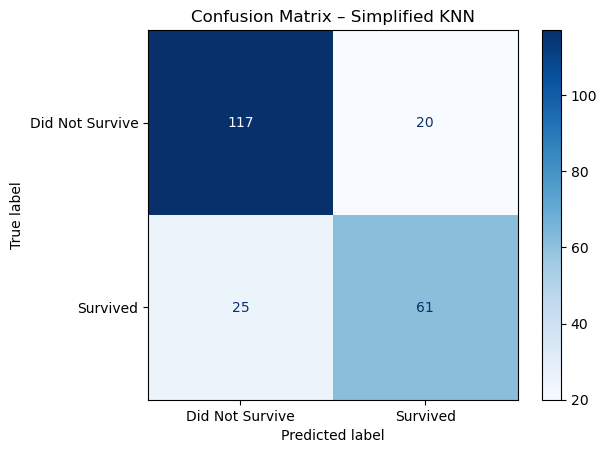

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(yr_test, yr_pred_knn)  

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Did Not Survive", "Survived"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Simplified KNN")
plt.show()


# Adjust the decision threshold

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

threshold = 0.45
y_pred_knn_045 = (yr_prob_knn >= threshold).astype(int)

print("Accuracy:", accuracy_score(yr_test, y_pred_knn_045))
print("Recall  :", recall_score(yr_test, y_pred_knn_045))
print("Precision:", precision_score(yr_test, y_pred_knn_045))


Accuracy: 0.7892376681614349
Recall  : 0.7325581395348837
Precision: 0.7241379310344828


# Precision–Recall trade-off

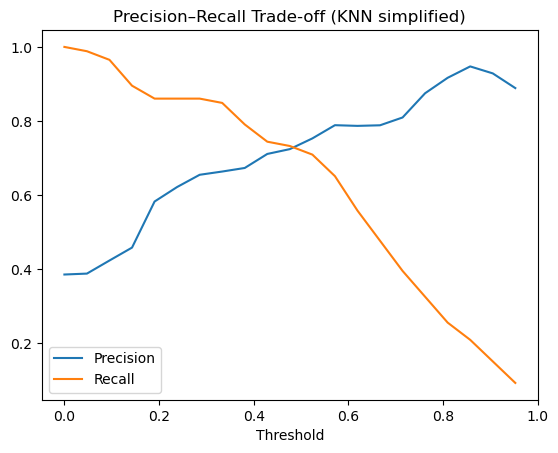

In [14]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(yr_test, yr_prob_knn)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision–Recall Trade-off (KNN simplified)")
plt.show()


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# --- Model 1: Full KNN (threshold = 0.50) ---
full_pred = y_pred_knn
full_prob = y_prob_knn

# --- Model 2: Simplified KNN reduced features (threshold = 0.50) ---
simple_pred_05 = yr_pred_knn
simple_prob = yr_prob_knn

# --- Model 3: Simplified KNN (threshold = 0.45) ---
simple_pred_045 = y_pred_knn_045

knn_results = pd.DataFrame([
    {
        "Model": "Full KNN (thr=0.50)",
        "Accuracy": accuracy_score(y_test, full_pred),
        "Precision": precision_score(y_test, full_pred),
        "Recall": recall_score(y_test, full_pred),
        "F1": f1_score(y_test, full_pred),
        "ROC AUC": roc_auc_score(y_test, full_prob)
    },
    {
        "Model": "Simplified KNN reduced features (thr=0.50)",
        "Accuracy": accuracy_score(yr_test, simple_pred_05),
        "Precision": precision_score(yr_test, simple_pred_05),
        "Recall": recall_score(yr_test, simple_pred_05),
        "F1": f1_score(yr_test, simple_pred_05),
        "ROC AUC": roc_auc_score(yr_test, simple_prob)
    },
    {
        "Model": "Simplified KNN (thr=0.45)",
        "Accuracy": accuracy_score(yr_test, simple_pred_045),
        "Precision": precision_score(yr_test, simple_pred_045),
        "Recall": recall_score(yr_test, simple_pred_045),
        "F1": f1_score(yr_test, simple_pred_045),
        "ROC AUC": roc_auc_score(yr_test, simple_prob)
    }
])

knn_results.round(3)


,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,Full KNN (thr=0.50),0.825,0.805,0.721,0.761,0.850
1,Simplified KNN reduced features (thr=0.50),0.798,0.753,0.709,0.731,0.827
2,Simplified KNN (thr=0.45),0.789,0.724,0.733,0.728,0.827
